### Step 4: Data Wrangling

The raw output data from coregistration cannot be passed into machine learning model directly. So, we need to combine, filter, select and transform the raw data. The processed data will be saved in a csv file. The last colomn are the labels(assuming we are mainly doing classification here). The other columns are features. 

The data selection is highly related to the specific research. The ultimate goal is to identify the features which are most important to the formation of deposit. For example, some researchers might think the distance to subducting trench is important. Others might think the sea floor age is cirtical. Come out with your own hypothesis, wrangle the data accordingly and then send the data into machine learning model to be evaluated. Repeat this process until we find the most important featueres and then we can train the machine learning model to predict deposit formation on new dataset. 

The following code cell will select data from coregistration outpout and create a machine learning dataset.

In [1]:
import numpy as np

#load data from coregistration output folder
input_data = np.genfromtxt('coreg_output/coregistration_input_data_example.csv',delimiter=',')
conv_data=np.genfromtxt('coreg_output/0_vector_subStats.out',delimiter=',')
seafloor_age_data=np.genfromtxt(
    'coreg_output/0_grid_EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid.out',delimiter=',')

#concatenate data together. The last column is the lables. 1 means deposit. 0 means non-deposit
#only the first 155 rows are deposits. 
data = np.c_[input_data, conv_data, seafloor_age_data, [1]*155+[0]*(len(input_data)-155)]

#print(np.isnan(conv_data).any(axis=1).sum())
all_non_nan_data = data[~np.isnan(data).any(axis=1)]#remove all the rows which contains nan

#the four features
#"Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction Obliquity"
data = all_non_nan_data[:155*2,(31,19,10,11,6,3)]
labels = all_non_nan_data[:155*2,-1]

np.savetxt('machine_learning_train_test_data.csv', np.c_[data, labels], delimiter=',', fmt='%1.4f')
print('The train and test data has been saved!')

#"Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction Obliquity", "lat", "age"
trench_data = all_non_nan_data[155*2-1:,(31,19,10,11,6,3)]
np.savetxt('machine_learning_trench_data.csv', trench_data, delimiter=',', fmt='%1.4f')

#now let's have a look at the data
import pandas as pd
#this file contains the sea floor ages retrieved from age
data = pd.read_csv("machine_learning_train_test_data.csv", 
                   header=None, names=['Seafloor Age', 'Distance to Trench Edge', 'Convergence Rate', 
                                       'Subduction Obliquity', 'Reconstructed Latitude', 'Age', 'Label']) 
data.head()#let's print the first 5 rows

The train and test data has been saved!


,Seafloor Age,Distance to Trench Edge,Convergence Rate,Subduction Obliquity,Reconstructed Latitude,Age,Label
0,41.43,25.77,10.88,-14.88,-27.06,6.0,1.0
1,40.11,4.78,2.72,-20.72,-50.18,230.0,1.0
2,47.62,22.38,11.88,-12.51,-29.97,12.0,1.0
3,48.01,25.60,10.87,-14.77,-26.82,9.0,1.0
4,44.98,25.65,10.87,-14.81,-26.93,8.0,1.0


#### The dataset has four features(dimensions). It is difficult to visualize the data in high dimensional space. So, let's plot it in two dimensions. 

Sometimes we can see a bit about the deposit distribution in the 2D plots. Sometimes we cannot. For example, it seems there are many deposits when the Subduction Obliquity is between -30 and -5 or when the birth age is between 0 and 70. The machine learning algorithms can help us to find out the distribution in a higher dimensional space. Machine learning cannot tell us the exact distribution. It can only give us an estimation with certain accuracy. 

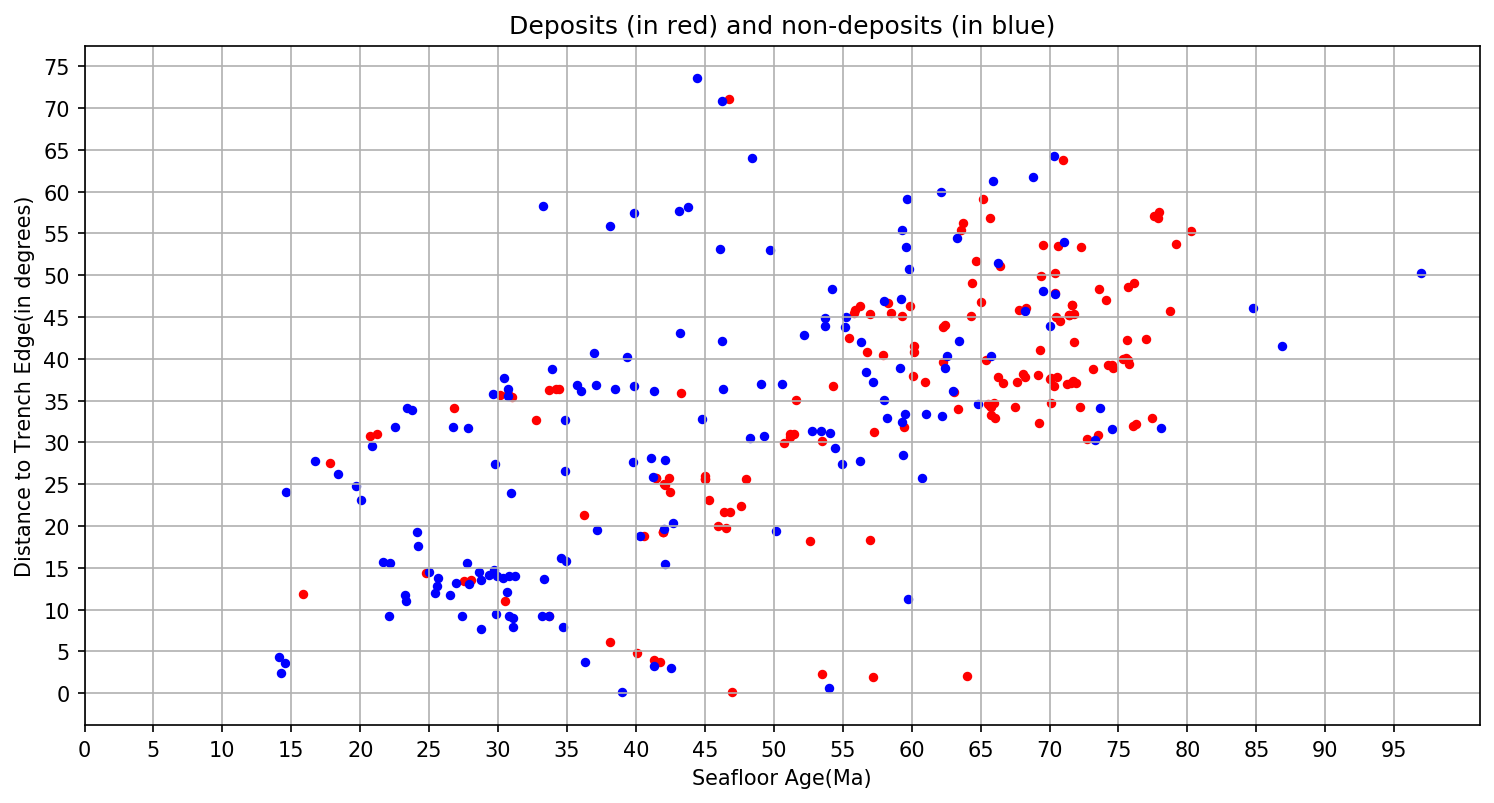

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()

ax.scatter(data.loc[:155,'Seafloor Age'], data.loc[:155,'Distance to Trench Edge'], 50, marker='.',c='red')
ax.scatter(data.loc[155:155*2,'Seafloor Age'], data.loc[155:155*2,'Distance to Trench Edge'], 50, marker='.',c='blue')
ax.set_xticks(np.arange(0,100,5))
ax.set_yticks(np.arange(0,80,5))
plt.xlabel('Seafloor Age(Ma)')
plt.ylabel('Distance to Trench Edge(in degrees)')
plt.title('Deposits (in red) and non-deposits (in blue)')
plt.grid()
plt.show()


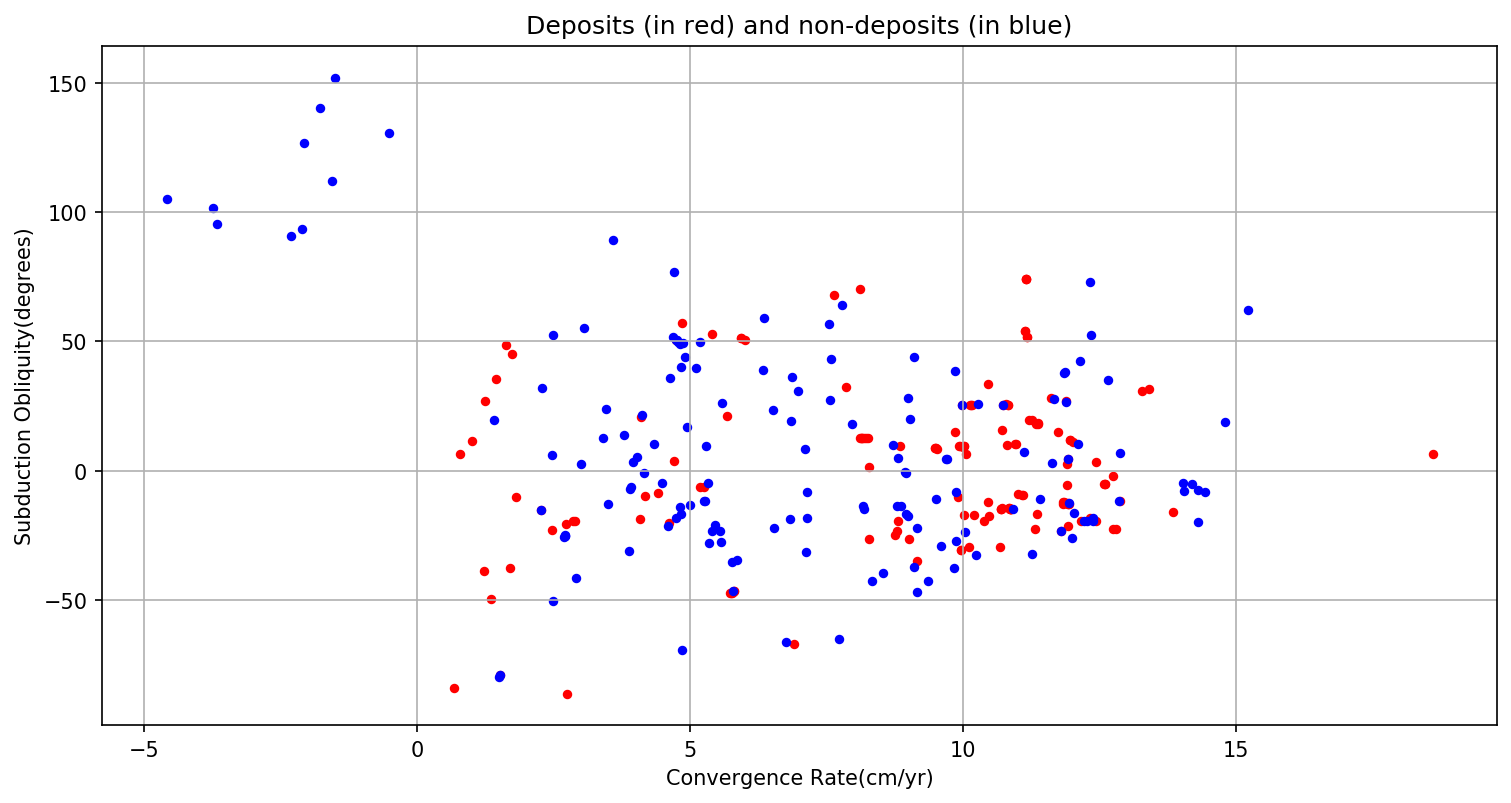

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()

ax.scatter(data.loc[:155,'Convergence Rate'], data.loc[:155,'Subduction Obliquity'], 50, marker='.',c='red')
ax.scatter(data.loc[155:155*2,'Convergence Rate'], data.loc[155:155*2,'Subduction Obliquity'], 50, marker='.',c='blue')

plt.xlabel('Convergence Rate(cm/yr)')
plt.ylabel('Subduction Obliquity(degrees)')
plt.title('Deposits (in red) and non-deposits (in blue)')
plt.grid()
plt.show()

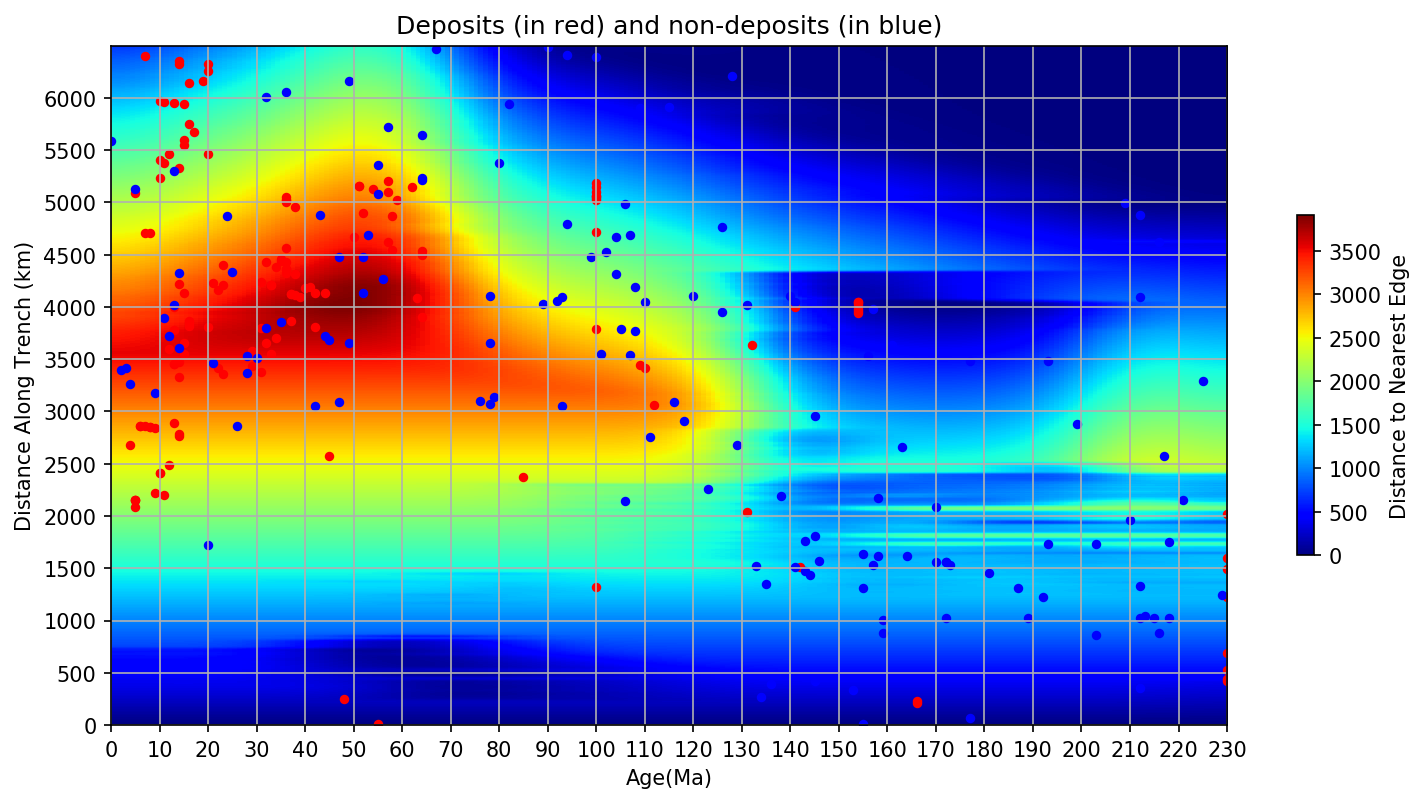

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
from scipy import misc, ndimage

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()
plt.xlim([0,230])
plt.ylim([0,6500])

distance_along_trench = all_non_nan_data[:,19] * 6371. * np.pi / 180
distance_to_edge = all_non_nan_data[:,18] * 6371. * np.pi / 180
ages = all_non_nan_data[:,3]

points=[]
values=[]
for age, dist_along_trench, dist_to_edge in zip(ages, distance_along_trench, distance_to_edge):
    points.append([age, dist_along_trench])
    values.append(dist_to_edge)
 
grid_x, grid_y = np.mgrid[0:231, 0:6501]
grid_data = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)
grid_data = ndimage.gaussian_filter(grid_data, sigma=10)
cb=plt.imshow(grid_data.T, extent=(0,230,0, 6500), origin='lower', aspect='auto',cmap=plt.cm.jet)
#cb=ax.scatter(np.array(points)[:,0], np.array(points)[:,1], c=values[:],cmap=plt.cm.jet,vmin=0,vmax=3000)
ax.scatter(ages[:155], distance_along_trench[:155], 50, marker='.',c='red')
ax.scatter(ages[155:155*2], distance_along_trench[155:155*2], 50, marker='.',c='blue')
ax.set_xticks(np.arange(0,240,10))
ax.set_yticks(np.arange(0,6500,500))
plt.xlabel('Age(Ma)')
plt.ylabel('Distance Along Trench (km)')
plt.title('Deposits (in red) and non-deposits (in blue)')
plt.grid()

fig.colorbar(cb, shrink=0.5, label='Distance to Nearest Edge')

plt.show()

#### Note:
The construction of multiple dimensional space(what we have done in this notebook) is important because the deposit distribution might be clearer to see in one space than the other. Choose your features carefully and wisely. And be aware of the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

#### This is the end of step 4 and now open the step 5 notebook
[5_Machine_Learning.ipynb](5_Machine_Learning.ipynb)